In [1]:
import starry
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pymc3.math as pmm
import pymc3_ext as pmx
import exoplanet
from starry_process import StarryProcess, MCMCInterface
from starry_process.math import cho_factor, cho_solve
import starry_process 
import theano
import aesara_theano_fallback.tensor as tt
from theano.tensor.slinalg import cholesky
from corner import corner
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from tqdm import tqdm

starry.config.quiet = True
np.random.seed(1)

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/anaconda3/envs/starry-env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper functions

In [2]:
def Inclination(name, testval=30):
    """
    An isotropic distribution for inclination angles (in degrees).
    
    """
    def logp(x):
        return tt.log(np.pi / 180 * tt.sin(x * np.pi / 180))

    def random(*args, **kwargs):
        return tt.arccos(pm.Uniform.dist(0, 1).random(*args, **kwargs)) * 180 / np.pi

    return pm.DensityDist(
        name,
        logp,
        random=random,
        initval=testval,
    )


def Angle(*args, **kwargs):
    """
    A uniform distribution for angles in [-180, 180).
    
    """
    if kwargs.get("testval", None) is not None:
        kwargs["testval"] *= np.pi / 180
    return 180 / np.pi * pmx.Angle(*args, **kwargs)


# Shorthand for the usual Uniform distribution
Uniform = pm.Uniform

In [15]:
def generate(t, params, seed=1, error=1e-3, visualize=True):
    """
    Generate a synthetic light curve.
    
    """
    # Set up the system
    map = starry.Map(15, 2)
    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]
    star = starry.Primary(map, m=params["star.m"]["truth"]) # *** maybe also `r`
    planet = starry.Secondary(
        starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]
    
    # Get the flux design matrix
    theta = (360 * t / params["star.prot"]["truth"]) % 360
    A = map.design_matrix(
        theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]
    ).eval()
    print(A.shape)
    
    # *** Draw 1 sample from the GP
    np.random.seed(seed)
    sp = StarryProcess(
        mu=params["gp.mu"]["truth"],
        sigma=params["gp.sigma"]["truth"],
        r=params["gp.r"]["truth"],
        c=params["gp.c"]["truth"],
        n=params["gp.n"]["truth"],
    )
    y = sp.sample_ylm().eval().reshape(-1)

    # Starry process Ylms are normalized so that they have
    # zero luminosity (i.e., a featureless star has Y_{0,0} = 0)
    # Let's renormalize it to unity, since that's the baseline
    # we want for transits
    # y[0] += 1
    
    # Compute the light curve
    flux0 = A @ y + 1


    # mu_ylm = sp.mean_ylm
    # mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    # mu_flux = tt.dot(A, mu_ylm)
    
    # Add photometric noise
    err = np.ones_like(flux0) * error
    flux = np.array(flux0)
    noise = np.random.randn(len(t)) * err
    flux += noise
    
    # *** Normalize the flux
    # med_flux = np.median(flux)
    # flux /= med_flux
    # err /= med_flux
    
    # Visualize the system
    if visualize:
        fig, ax = plt.subplots(1, 2, figsize=(20, 8))
        idx = (zo > 0) | (xo ** 2 + yo ** 2 > 1)
        ax[0].plot(xo[idx], yo[idx], "k.", ms=1);
        ax[0].set_aspect(1)
        ax[0].axis("off")
        map[:, :] = y
        map.show(ax=ax[0])
        ax[0].set_ylim(-3, 3)
        idx = (zo > 0) & (xo ** 2 + yo ** 2 < 1)
        lat = 180 / np.pi * np.arcsin(yo[idx])
        lon = 180 / np.pi * np.arcsin(xo[idx] / np.sqrt(1 - yo[idx] ** 2)) - theta[idx]
        lon = (lon + 180) % 360 - 180
        mask = np.append(np.array(lon[1:] > lon[:-1], dtype=float), 0)
        mask[mask == 1] = np.nan
        map.show(ax=ax[1], projection="rect")
        ax[1].plot(lon, lat + mask, "k-");
    
    return flux, err, med_flux, mu_flux

Based on Hogg's notes: https://ui.adsabs.harvard.edu/abs/2020arXiv200514199H/abstract,
I have $$ln L_m = -\frac{1}{2} r_m^T \Sigma^{-1} r_m - \frac{1}{2}ln\vert\Sigma\vert - \frac{K}{2} ln(2\pi)$$
$$r_m = f_m - \mu$$
from eq. (19) and (20):
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s\vert  \vert\Sigma_s^{-1}\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert $$
$$\vert\Sigma\vert = \vert\Sigma_d\vert \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
$$ln \vert\Sigma\vert = ln \vert\Sigma_d\vert + ln \vert\Sigma_s A^T\Sigma_d^{-1} A+I\vert$$
from eq. (24):
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (\Sigma_s^{-1}+A^T\Sigma_d^{-1}A)^{-1}A^T\Sigma_d^{-1}$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A (I+\Sigma_s A^T\Sigma_d^{-1}A)^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$U = I+\Sigma_s A^T\Sigma_d^{-1}A$$
$$\Sigma^{-1} = \Sigma_d^{-1} - \Sigma_d^{-1} A U^{-1}\Sigma_s A^T\Sigma_d^{-1}$$
$$Q = r_m^T \Sigma^{-1} r_m = r_m^T(\Sigma_d^{-1} - \Sigma_d^{-1} A \Sigma_s U^{-1}A^T\Sigma_d^{-1})r_m$$
$$v = A^T\Sigma_d^{-1}r_m = A^T r_m/\sigma^2$$
$$v^T = r_m^T\Sigma_d^{-1}A$$
$$Q = r_m^T\Sigma_d^{-1}r_m - v^T \Sigma_s U^{-1}v$$

In [16]:
def bin_out_of_transit(t, flux, err, params, dt=0.1, binsize=30):
    """
    Bin the out of transit points to speed things up.
    
    """
    # Find in-transit and out-of-transit points
    idx = np.zeros(len(t), dtype=bool)
    ntransits = int(np.ceil(t[-1] / params["planet.porb"]["truth"]))
    for n in range(ntransits):
        t0 = params["planet.t0"]["truth"] + n * params["planet.porb"]["truth"]
        idx |= ((t > t0 - dt) & (t < t0 + dt))
    t_in = t[idx]
    f_in = flux[idx]
    t_out = t[~idx]
    f_out = flux[~idx]

    # Make the size of the out-of-transit array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t_out) % binsize
    t_out = t_out[:-trim]
    f_out = f_out[:-trim]

    # We need to be careful not to bin *across* the transit, so
    # let's NaN-out points right _before_ each transit
    f_out[np.where(np.diff(t_out) > 0.1)] = np.nan

    # Bin the out-of-transit data
    t_out = t_out.reshape(-1, binsize).mean(axis=1)
    f_out = f_out.reshape(-1, binsize).mean(axis=1)

    # Remove any nans (the averages *across* transits)
    idx = np.isnan(f_out)
    t_out = t_out[~idx]
    f_out = f_out[~idx]

    # Error arrays
    e_in = err[0] * np.ones_like(t_in)
    e_out = (err[0] / np.sqrt(binsize)) * np.ones_like(t_out)

    # Sort and merge the arrays
    t_ = np.concatenate((t_in, t_out))
    f_ = np.concatenate((f_in, f_out))
    e_ = np.concatenate((e_in, e_out))
    idx = np.argsort(t_)
    t_ = t_[idx]
    flux_ = f_[idx]
    err_ = e_[idx]

    return t_, flux_, err_

some linear algebra:
$$\Sigma_d^{-1}r_m = r_m\frac{1}{\sigma^2}$$
$$r_m^T\Sigma_d^{-1} = (r_m\frac{1}{\sigma^2})^T$$
$$r_m^T\Sigma_d^{-1}r_m = r_m^2/\sigma^2$$

Solving for mean and covariance of $f_{obs}$
$$m=1/\alpha$$
$$f_{obs} = f_{true}{\alpha}+\epsilon$$
$$f_{true} \sim \mathcal{N}(\mu,\Sigma)$$
$$\epsilon \sim \mathcal{N}(0,\sigma^2 I)$$
$$f_{obs} \sim \mathcal{N}(\frac{\mu}{m},\frac{\Sigma}{m^2}+\sigma^2I)$$
Now, I need to change $\Sigma$:
$$\tilde\Sigma^{-1} = (\frac{1}{m^2}\Sigma)^{-1} = m^2\Sigma^{-1}$$
$$\tilde Q = m^2 Q$$
$$ln\vert\tilde\Sigma\vert = ln\vert\frac{1}{m^2}\Sigma\vert = ln((\frac{1}{m^2})^n\vert\Sigma\vert) = -2n ln(m)+ ln\vert\Sigma\vert$$

In [17]:
def gp_model(t, flux, err, params):

    # Helper function to instantiate parameters
    def parameter(name):
        param = params[name]
        if param.get("free", False):
            args = param.get("args", [])
            kwargs = param.get("kwargs", {})
            testval = param.get("testval", param["truth"])
            return param["dist"](name, *args, testval=testval, **kwargs)
        else:
            return param["truth"]
    
    
    starry.config.lazy = True
    
    with pm.Model() as model:

        # Instantiate the system
        map = starry.Map(15, 2)
        map.inc = parameter("star.inc")
        map[1] = parameter("star.u1")
        map[2] = parameter("star.u2")
        star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
        planet = starry.Secondary(
            starry.Map(),
            inc=parameter("planet.inc"),
            ecc=parameter("planet.ecc"),
            Omega=parameter("planet.Omega"),
            w=parameter("planet.w"),
            porb=parameter("planet.porb"),
            t0=parameter("planet.t0"),
        )
        sys = starry.System(star, planet)
        xo, yo, zo = sys.position(t)

        # Get the flux design matrix
        theta = (360 * t / parameter("star.prot")) % 360
        A = map.design_matrix(
            theta=theta,
            xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
            yo=yo[1],
            zo=zo[1],
            ro=parameter("planet.r"),
        )

        # Instantiate the GP
        # sigma = pm.Uniform("sigma", 1.0, 10.0)
        sp = StarryProcess(
            mu=parameter("gp.mu"),
            sigma=parameter("gp.sigma"),
            # sigma=sigma,
            r=parameter("gp.r"),
            c=parameter("gp.c"),
            n=parameter("gp.n"),
            marginalize_over_inclination=False,  # *** we know the inclination
            normalized=False,  # *** we're modeling the normalization explicitly
        )
        norm = parameter("gp.norm")
        
        # A = A / norm
        

        Sigma_s = sp.cov_ylm 
        mu_ylm = sp.mean_ylm
        # mu_ylm = tt.inc_subtensor(mu_ylm[0],1)
        mu_flux = tt.dot(A, mu_ylm) #/ norm
        
        pm.Deterministic('mu_ylm',mu_flux)
        pm.Deterministic('Sigma_ylm',Sigma_s)

        K = len(t)

        U = np.eye(256) + tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

        log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
        # log_sigmadet -= 2*256*tt.log(norm)

        r = tt.as_tensor_variable(flux) - mu_flux - norm
        v = tt.dot(A.T,(r/tt.square(err)))
        Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

        loglike = -0.5 * Q
        loglike -= 0.5  * log_sigmadet
        loglike -= 0.5 * K * tt.log(2 * np.pi)

        pm.Potential("lnlike", loglike)

        
        return model

## Generate a light curve

(721, 256)


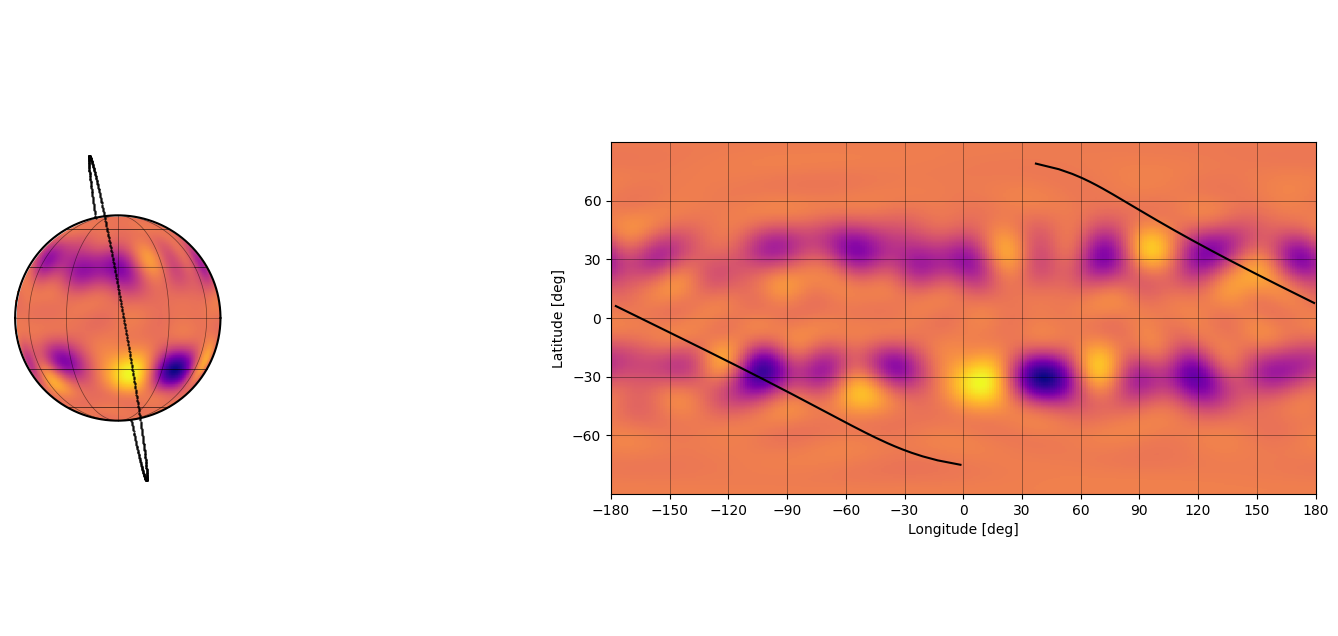

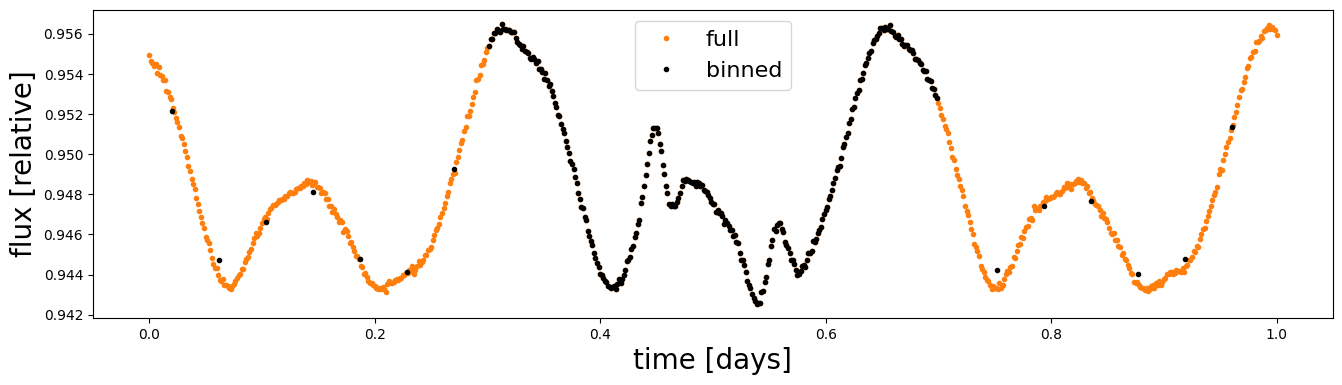

In [18]:
# *** True parameters & priors
params = {
    "planet.inc": {"truth": 88.0, "dist": Inclination},
    "planet.ecc": {"truth": 0.0, "dist": Uniform, "args": [0.0, 0.4]},
    "planet.Omega": {"truth": 100, "dist": Angle},
    "planet.w": {"truth": 0.0, "dist": Angle},
    "planet.porb": {"truth": 1.0, "dist": Uniform, "args": [0.975, 1.025]},
    "planet.t0": {"truth": 0.5, "dist": Uniform, "args": [0.475, 0.525]},
    "planet.r": {"truth": 0.1, "dist": Uniform, "args": [0.06, 0.14]},
    "star.inc": {"truth": 90, "dist": Inclination},
    "star.m": {"truth": 0.5, "dist": Uniform, "args": [0.4, 0.6]},
    "star.u1": {"truth": 0.4, "dist": Uniform, "args": [0.0, 0.6]},
    "star.u2": {"truth": 0.2, "dist": Uniform, "args": [0.0, 0.4]},
    "star.prot": {"truth": 0.34, "dist": pm.Uniform, "args": [0.1, 1.0]},
    "gp.r": {"truth": 10, "dist": Uniform, "args": [5.0, 25.0]},
    "gp.c": {"truth": 0.1, "dist": Uniform, "args": [0.01, 0.5]},
    "gp.n": {"truth": 20, "dist": Uniform, "args": [1, 30]},
    "gp.mu": {"truth": 30, "dist": Uniform, "args": [0.0, 80.0]},
    "gp.sigma": {"truth": 5, "dist": Uniform, "args": [1.0, 10]},
    "gp.norm": {"truth": 1, "dist": Uniform, "args": [0.8, 1.2]}
}

# *** Time array (1 day @ 2 min cadence)
t = np.arange(0, 1, 2 / 24 / 60)

# Get the light curve
flux, err, med_flux, mu_flux = generate(t, params, error=1e-4)

# Get the binned light curve
t_, flux_, err_ = bin_out_of_transit(t, flux, err, params, dt=0.2)

# Plot the data
fig, ax = plt.subplots(1, figsize=(16, 4))
ax.plot(t, flux, "C1.", alpha=1, label="full")
ax.plot(t_, flux_, "k.", label="binned")
ax.set_ylabel("flux [relative]", fontsize=20)
ax.set_xlabel("time [days]", fontsize=20)
ax.legend(fontsize=16);

In [19]:
params['gp.norm']['truth']

1

# Inference

In [20]:
# Set some free params & get the model
p = dict(params)
p["gp.mu"]["free"] = True
p["gp.sigma"]["free"] = True
p["gp.n"]["free"] = True
p["gp.c"]["free"] = True
p["gp.r"]["free"] = True
p["gp.norm"]["free"] = True
free = [x for x in p.keys() if p[x].get("free", False)]
model = gp_model(t, flux, err, p)

In [21]:
from starry_process import MCMCInterface

with model:
    mci = MCMCInterface()

In [22]:
x = mci.optimize()
print(mci.transform(x, varnames=free))

message: Desired error not necessarily achieved due to precision loss.
logp: 5485.280049150037 -> 5487.106618658091
100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

[10.15464798  0.10028952 13.13341478 28.31215772  3.86258405  0.98434184]


In [23]:
nwalkers = 15
p0 = mci.get_initial_state(nwalkers)

In [24]:
mci.logp(x)

array(5487.10661866)

In [25]:
import emcee

# Number of parameters
ndim = p0.shape[1]

# Instantiate the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, mci.logp)

In [26]:
def run_sampler_to_convergence(sampler, xs, nsamp):
    while True:
        sampler.reset()
        sampler.run_mcmc(xs, int(round(nsamp/2)), progress=True)
        xs = sampler.chain[:,-1,:]
        mean_lnprobs = np.mean(sampler.lnprobability, axis=0)

        if mean_lnprobs[-1] < mean_lnprobs[0]:
            break

    # Burned in, at least in the likelihood
    nfac = 1
    while True:
        xs = sampler.chain[:,-1,:]
        sampler.reset()
        sampler.run_mcmc(xs, nsamp, progress=True, thin_by=nfac)

        ac = sampler.get_autocorr_time(quiet=True)

        ac = np.max(ac)

        Nact = nsamp / ac

        if Nact > 50:
            break
        nfac *= 2

    return sampler

In [27]:
sampler.reset()

In [28]:
nsteps = 64000

In [29]:
sampler_new = run_sampler_to_convergence(sampler, p0, nsteps)

  0%|          | 15/32000 [00:24<14:23:09,  1.62s/it]

In [13]:
samples_fromfile1 = az.from_netcdf('sampler_64000_gps_samples.nc')

In [14]:
# transformed samples converted to numpy array for plotting purposes
samples_fromfile1 = samples_fromfile1.posterior.to_array()[0]

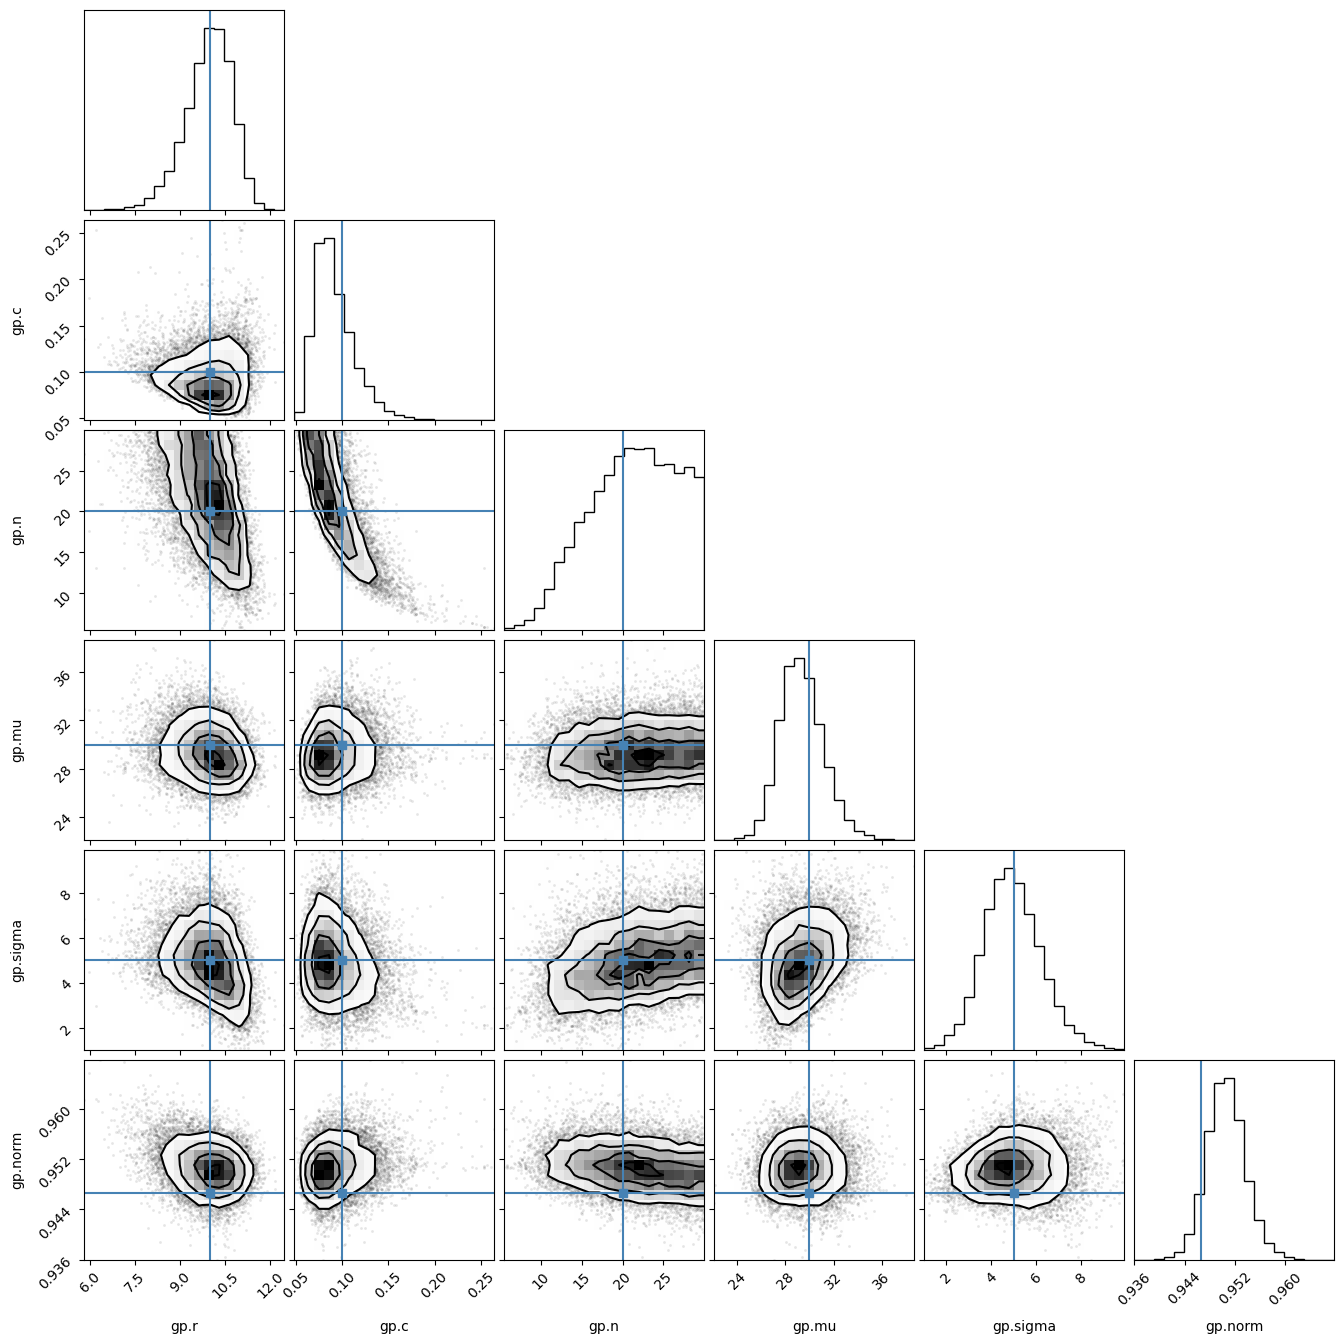

In [15]:
corner(np.array(samples_fromfile1), labels=free, truths=[params[x]["truth"] for x in free]);

In [16]:
# Helper function to instantiate parameters
def parameter(name):
    param = params[name]
    if param.get("free", False):
        args = param.get("args", [])
        kwargs = param.get("kwargs", {})
        testval = param.get("testval", param["truth"])
        return param["dist"](name, *args, testval=testval, **kwargs)
    else:
        return param["truth"]
    
    
starry.config.lazy = True
    
with pm.Model() as model1:

    # Instantiate the system
    map = starry.Map(15, 2)
    map.inc = parameter("star.inc")
    map[1] = 0.0
    map[2] = 0.0
    star = starry.Primary(map, m=parameter("star.m")) # *** maybe also `r` for the star
    planet = starry.Secondary(
        starry.Map(),
        inc=parameter("planet.inc"),
        ecc=parameter("planet.ecc"),
        Omega=parameter("planet.Omega"),
        w=parameter("planet.w"),
        porb=parameter("planet.porb"),
        t0=parameter("planet.t0"),
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)

    # Get the flux design matrix
    theta = (360 * t / parameter("star.prot")) % 360
    A = map.design_matrix(
        theta=theta,
        xo=xo[1], # *** these were wrong! [0] = star; [1] = planet
        yo=yo[1],
        zo=zo[1],
        ro=parameter("planet.r"),
    )

    # Instantiate the GP
    # sigma = pm.Uniform("sigma", 1.0, 10.0)
    sp = StarryProcess(
        mu=parameter("gp.mu"),
        sigma=parameter("gp.sigma"),
        # sigma=sigma,
        r=parameter("gp.r"),
        c=parameter("gp.c"),
        n=parameter("gp.n"),
        marginalize_over_inclination=False,  # *** we know the inclination
        normalized=False,  # *** we're modeling the normalization explicitly
    )
    norm = parameter("gp.norm")
    
    A = A / norm
        
    
    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm) #/ norm
    
    mu_from_model = pm.Deterministic('mu_flux',mu_flux)
    Sigma_ylm_from_model = pm.Deterministic('Sigma_ylm',Sigma_s)

    K = len(t)

    U = np.eye(256) +tt.dot(Sigma_s, tt.dot(A.T, A/tt.square(err[:,None])))

    log_sigmadet = 2*tt.sum(tt.log(err)) + pmm.logdet(U) 
    # log_sigmadet -= 2*256*tt.log(norm)

    r = tt.as_tensor_variable(flux) - mu_flux
    v = tt.dot(A.T,(r/tt.square(err)))
    Q = tt.sum(tt.square(r/err)) - tt.dot(v.T,tt.slinalg.solve(U,tt.dot(v,Sigma_s)))

    loglike = -0.5 * Q
    loglike -= 0.5  * log_sigmadet
    loglike -= 0.5 * K * tt.log(2 * np.pi)

    pm.Potential("lnlike", loglike)


In [17]:
mu_from_model = pmx.eval_in_model(model=model1, var=mu_from_model)

In [18]:
Sigma_ylm_from_model = pmx.eval_in_model(model=model1, var=Sigma_ylm_from_model)

In [19]:
samples_dict = {}

In [20]:
for n, i in enumerate(free):
    samples_dict[i] = np.array(samples_fromfile1)[:,n]

In [21]:
params['gp.mu']['truth']

30

In [22]:
samples_dict['gp.mu']

array([30.61379615, 33.47092886, 29.18913558, ..., 27.18950123,
       28.40717334, 29.15203878])

Text(0, 0.5, 'Normalized Flux')

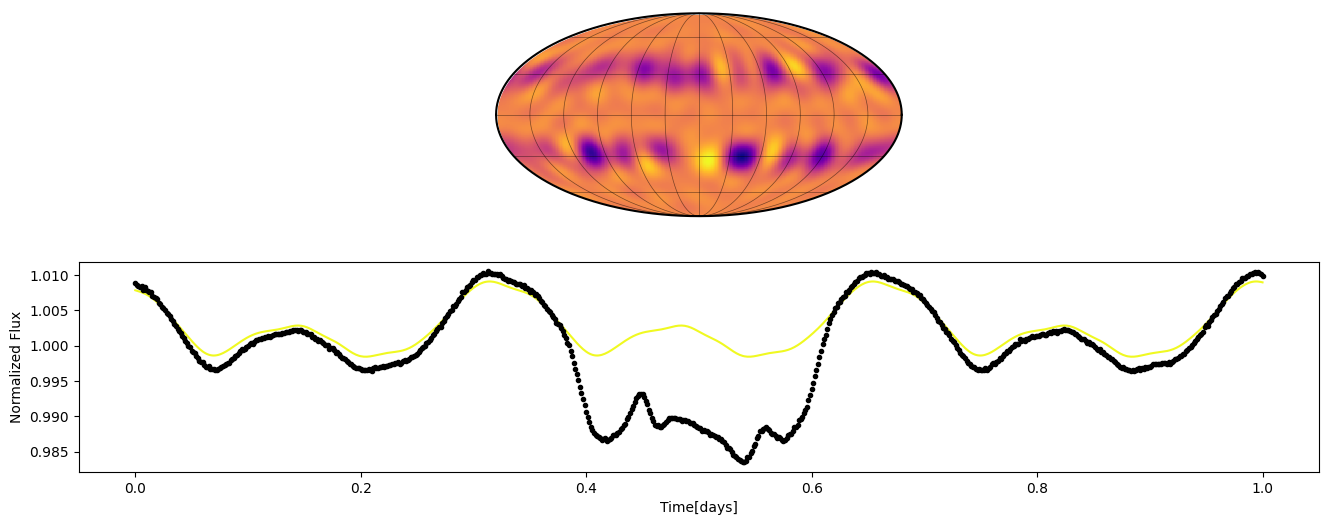

In [23]:
nsamples = 1
# norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")

map = starry.Map(15,2)

# Draw samples
rand_index = np.random.randint(0,np.array(samples_fromfile1).shape[0])

# the sp params should all be drawn from the same sample
sp = StarryProcess(
        mu=samples_dict['gp.mu'][rand_index],
        sigma=samples_dict['gp.sigma'][rand_index],
        r=samples_dict['gp.r'][rand_index],
        c=samples_dict['gp.c'][rand_index],
        n=samples_dict['gp.n'][rand_index],
        marginalize_over_inclination=False,  
        normalized=False, 
    )

# sp = StarryProcess(
#         mu=params["gp.mu"]["truth"],
#         sigma=params["gp.sigma"]["truth"],
#         r=params["gp.r"]["truth"],
#         c = params["gp.c"]["truth"],
#         n=params["gp.n"]["truth"],
#         marginalize_over_inclination=False,  
#         normalized=False, 
#     )

# y = sp.sample_ylm_conditional(t=t, flux=flux, data_cov=err**2, nsamples=nsamples).eval()
y = sp.sample_ylm(nsamples=nsamples).eval()
fig, ax = plt.subplots(
    2,
    figsize=(16, 6),
)
# Normalize so that the background photosphere
# has unit intensity (for plotting)
y[:, 0] += 1

# y *= np.pi

flux_sys=np.zeros((nsamples,len(t)))

map.inc = params["star.inc"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]

star = starry.Primary(map, m=params["star.m"]["truth"]) 
planet = starry.Secondary(
starry.Map(),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    w=params["planet.w"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]

theta = (360 * t / params["star.prot"]["truth"]) % 360

A = map.design_matrix(
        theta=theta,
        xo=xo[1], 
        yo=yo[1],
        zo=zo[1],
        ro=params["planet.r"]["truth"],
    ).eval()

A = A / samples_dict['gp.norm'][rand_index]

Sigma_s = sp.cov_ylm 
mu_ylm = sp.mean_ylm
mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
mu_flux = tt.dot(A, mu_ylm)
# theta = 360 * t


for k in range(nsamples):
    y[k] = y[k].reshape(-1)

    map[:,:] = y[k]
    map.show(ax=ax[0], projection="moll")

    # Compute the light curve
    flux_sys = A @ y[k]  
    # flux_sys = map.flux(theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]).eval() / np.array(samples_fromfile1)[rand_index,5]

    # *** Normalize the flux
    # flux_sys -= np.mean(flux_sys.eval())
    # flux_sys[k] *= 1e3

    plt.plot(t, flux_sys, color=cmap(k/5))
    # plt.plot(t,mu_ylm_from_model, color=cmap(k/5))
plt.plot(t,flux,'k.')
# plt.plot(t, mu_eval(), 'k.')
plt.xlabel('Time[days]')
plt.ylabel('Normalized Flux')

    



In [24]:
samples_dict['gp.norm'][rand_index]

0.9522796443959596

Text(0, 0.5, 'Normalized Flux')

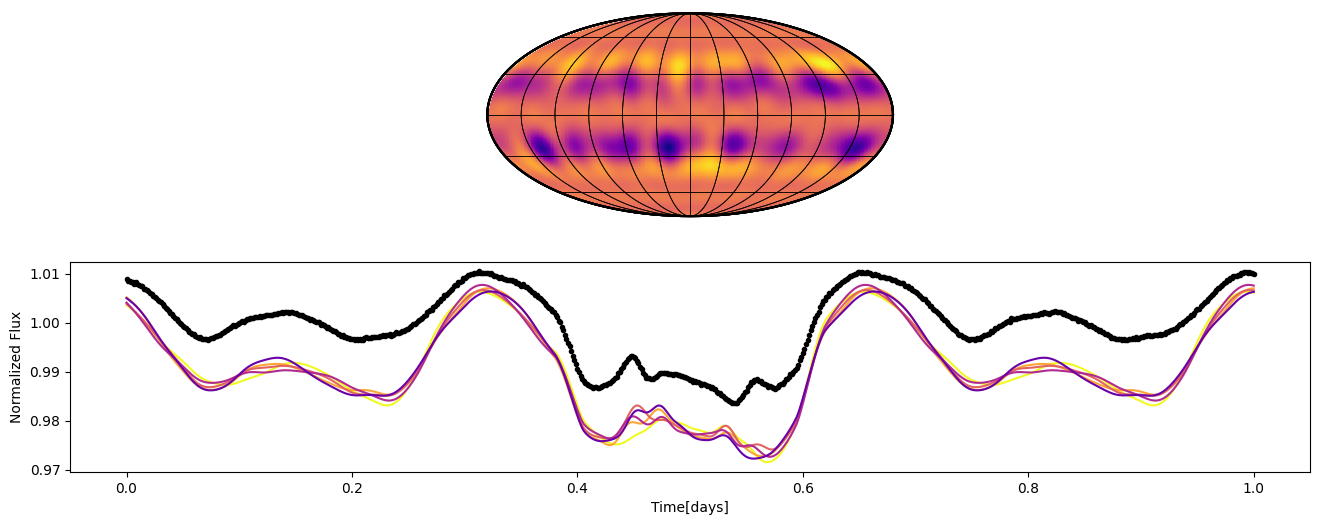

In [34]:
nsamples = 5
# norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")

map = starry.Map(15,2)

# Draw samples
rand_index = np.random.randint(0,np.array(samples_fromfile1).shape[0])

# the sp params should all be drawn from the same sample
sp = StarryProcess(
        mu=samples_dict['gp.mu'][rand_index],
        sigma=samples_dict['gp.sigma'][rand_index],
        r=samples_dict['gp.r'][rand_index],
        c=samples_dict['gp.c'][rand_index],
        n=samples_dict['gp.n'][rand_index],
        marginalize_over_inclination=False,  
        normalized=False, 
    )

y = sp.sample_ylm_conditional(t=t, flux=flux, data_cov=err**2, nsamples=nsamples, baseline_mean=1/samples_dict['gp.norm'][rand_index], p=params['star.prot']['truth'],i=params['star.inc']['truth']).eval()
# y = sp.sample_ylm(nsamples=nsamples).eval()
fig, ax = plt.subplots(
    2,
    figsize=(16, 6),
)
# Normalize so that the background photosphere
# has unit intensity (for plotting)
y[:, 0] += 1

# y *= np.pi

flux_sys=np.zeros((nsamples,len(t)))

map.inc = params["star.inc"]["truth"]
map[1] = params["star.u1"]["truth"]
map[2] = params["star.u2"]["truth"]

star = starry.Primary(map, m=params["star.m"]["truth"]) 
planet = starry.Secondary(
starry.Map(),
    inc=params["planet.inc"]["truth"],
    ecc=params["planet.ecc"]["truth"],
    Omega=params["planet.Omega"]["truth"],
    w=params["planet.w"]["truth"],
    porb=params["planet.porb"]["truth"],
    t0=params["planet.t0"]["truth"],
)
sys = starry.System(star, planet)
xo, yo, zo = sys.position(t)
xo = xo.eval()[1]
yo = yo.eval()[1]
zo = zo.eval()[1]

theta = (360 * t / params["star.prot"]["truth"]) % 360

A = map.design_matrix(
        theta=theta,
        xo=xo[1], 
        yo=yo[1],
        zo=zo[1],
        ro=params["planet.r"]["truth"],
    ).eval()

# A = A / samples_dict['gp.norm'][rand_index]

Sigma_s = sp.cov_ylm 
mu_ylm = sp.mean_ylm
mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
mu_flux = tt.dot(A, mu_ylm)
# theta = 360 * t


for k in range(nsamples):
    y[k] = y[k].reshape(-1)

    map[:,:] = y[k]
    map.show(ax=ax[0], projection="moll")

    # Compute the light curve
    # flux_sys = A @ y[k] / samples_dict['gp.norm'][rand_index]
    flux_sys = map.flux(theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]).eval() / samples_dict['gp.norm'][rand_index]

    # *** Normalize the flux
    # flux_sys -= np.mean(flux_sys.eval())
    # flux_sys[k] *= 1e3

    plt.plot(t, flux_sys, color=cmap(k/5))
    # plt.plot(t,mu_ylm_from_model, color=cmap(k/5))
plt.plot(t,flux,'k.')
# plt.plot(t, mu_flux.eval(), 'r.')
plt.xlabel('Time[days]')
plt.ylabel('Normalized Flux')

    

Text(0, 0.5, 'Normalized Flux')

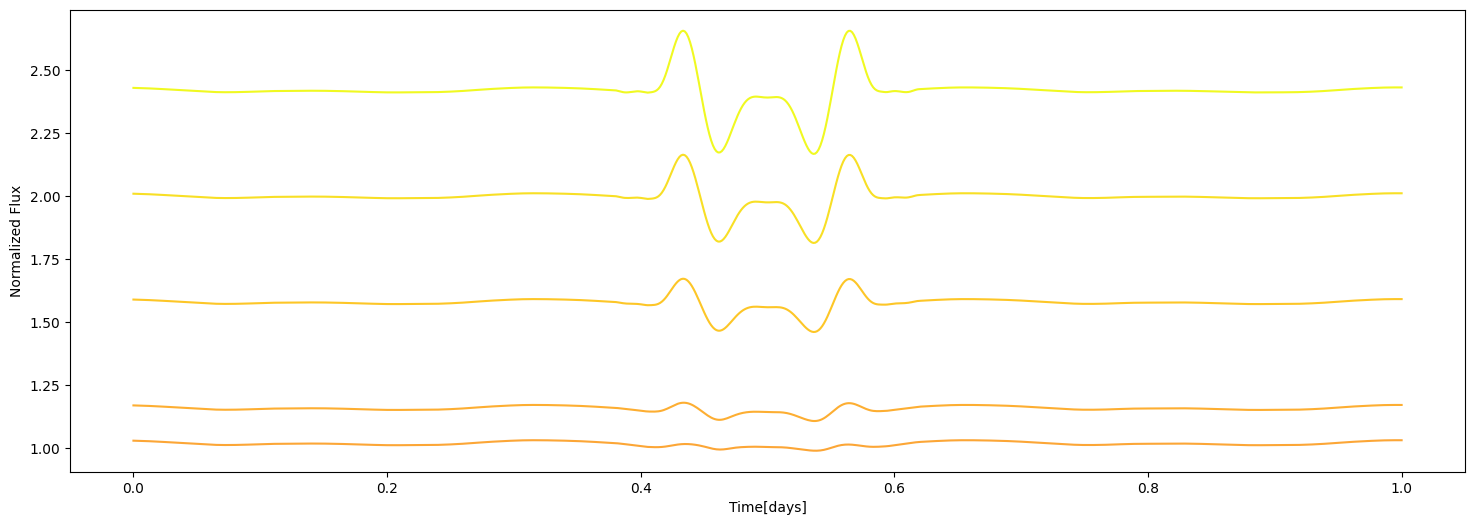

In [66]:
nsamples = 1
# norm = Normalize(vmin=0.5, vmax=1.1)
cmap = plt.get_cmap("plasma_r")
baseline = [0,0.3,0.6,0.9,1]

map = starry.Map(15,2)

# Draw samples
rand_index = np.random.randint(0,np.array(samples_fromfile1).shape[0])

plt.figure(figsize=(18,6))

for k in baseline:

    # the sp params should all be drawn from the same sample
    sp = StarryProcess(
            mu=samples_dict['gp.mu'][rand_index],
            sigma=samples_dict['gp.sigma'][rand_index],
            r=samples_dict['gp.r'][rand_index],
            c=samples_dict['gp.c'][rand_index],
            n=samples_dict['gp.n'][rand_index],
            marginalize_over_inclination=False,  
            normalized=False, 
        )

    y = sp.sample_ylm_conditional(t=t, flux=flux, data_cov=err**2, nsamples=nsamples, baseline_mean=k, p=params['star.prot']['truth'],i=params['star.inc']['truth']).eval()
    # y = sp.sample_ylm(nsamples=nsamples).eval()
    # Normalize so that the background photosphere
    # has unit intensity (for plotting)
    y[:, 0] += 1

    # y *= np.pi

    flux_sys=np.zeros((nsamples,len(t)))

    map.inc = params["star.inc"]["truth"]
    map[1] = params["star.u1"]["truth"]
    map[2] = params["star.u2"]["truth"]

    star = starry.Primary(map, m=params["star.m"]["truth"]) 
    planet = starry.Secondary(
    starry.Map(),
        inc=params["planet.inc"]["truth"],
        ecc=params["planet.ecc"]["truth"],
        Omega=params["planet.Omega"]["truth"],
        w=params["planet.w"]["truth"],
        porb=params["planet.porb"]["truth"],
        t0=params["planet.t0"]["truth"],
    )
    sys = starry.System(star, planet)
    xo, yo, zo = sys.position(t)
    xo = xo.eval()[1]
    yo = yo.eval()[1]
    zo = zo.eval()[1]

    theta = (360 * t / params["star.prot"]["truth"]) % 360

    Sigma_s = sp.cov_ylm 
    mu_ylm = sp.mean_ylm
    mu_ylm = tt.inc_subtensor(mu_ylm[0], 1)
    mu_flux = tt.dot(A, mu_ylm)
    # theta = 360 * t

    y = y.reshape(-1)

    map[:,:] = y

    flux_sys = map.flux(theta=theta, xo=xo, yo=yo, zo=zo, ro=params["planet.r"]["truth"]).eval() 

    plt.plot(t, flux_sys, color=cmap(k/5))

plt.xlabel('Time[days]')
plt.ylabel('Normalized Flux')

    

Text(0, 0.5, 'Normalized Flux')

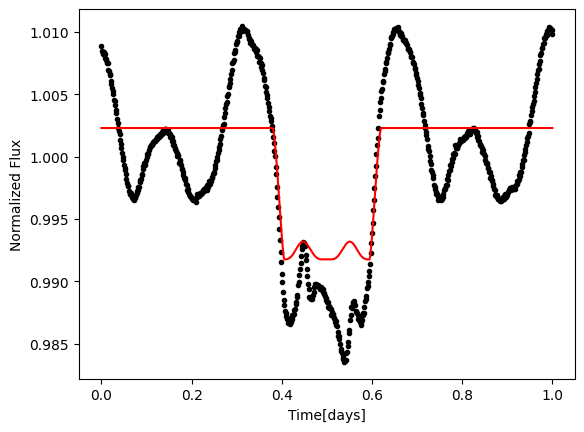

In [15]:
plt.plot(t,flux,'k.')
plt.plot(t, mu_from_model, 'r')
plt.xlabel('Time[days]')
plt.ylabel('Normalized Flux')
